In [1]:
from Ocean_01_F_Annotate_Ops_Module import *
print('\nWelcome to Ocean Annotate: On Jupyter running Python {}'.format(sys.version_info[0]))

OOI RCA Oregon Slope Base: Shallow Profiler status report
For March 2021:
31 days, translates to 279 possible profiles
Actual:
262 profiles; 29 at local midnight and 30 at local noon

Welcome to Ocean Annotate: On Jupyter running Python 3


In [2]:
# open a default fluorometer dataset: Full time resolution, RCA OSB SP
D = xr.open_dataset('../../data/rca/fluor/osb/2021/flort_fullres.nc')
D = D.swap_dims({'obs':'time'})
# Save .dropna() until after running the median filter; this preserves more information?
# D = D.dropna('time')
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})
D = D[['chlora', 'fdom', 'backscatter', 'seawater_scattering_coefficient', \
       'practical_salinity', 'seawater_temperature', 'int_ctd_pressure'    ]]
D = D.drop(['obs', 'lat', 'lon'])
D = D.reset_coords()
D.attrs={}
print('This dataset runs ' + str(dt64(D.time[0].data))[:10] + ' through ' + str(dt64(D.time[-1].data))[:10] + ' (Zulu)')

This dataset runs 2021-01-23 through 2021-04-14 (Zulu)


In [3]:
# Working with the profile metadata (already constructed): Establish profile
#     boundaries for this dataset. Profile data resides in a pandas datafraome 'p'.
#     p.shape gives 1855 x 6; so 1855 profiles are available; 0 is 'begin' and 1854
#     is 'end'; so the constraint of the actual dataset leads to indices 'start' 
#     and 'stop': Close to 3 months of data.
# 
data_time_start = dt64(D.time[0].data)
data_time_stop  = dt64(D.time[-1].data)
p_index_begin = 0                                     # begin/end refers to the profile data for this year 
p_index_start = p_index_begin                         # start/stop refers to profile indices within this dataset
p_index_end   = p.shape[0]
for i in range(p_index_end):                          # 0 1 2 ... 1854
    this_ascent_start = dt64(p['ascent_start'][i])
    if this_ascent_start > data_time_start:
        p_index_start = i
        print('Start: Compare data begins at', data_time_start, '< first ascent at', this_ascent_start)
        break

for i in range(p_index_start, p_index_end):                         # 180 181 182 ... 1854
    this_descent_end = dt64(p['descent_end'][i])
    if this_descent_end > data_time_stop:                           # as the data runs out before profile [i] does: Back up one profile
        p_index_stop = i - 1
        this_descent_end = dt64(p['descent_end'][p_index_stop])     # adjust to previous profile
        print('Stop: Compare data stops at', data_time_stop, '> stop of last profile at', this_descent_end, ': profile indices run', p_index_start, '...', p_index_stop, '(', str(p_index_stop-p_index_start+1), 'profiles )')
        break        

Start: Compare data begins at 2021-01-23T12:00:00.228180992 < first ascent at 2021-01-23T13:32:00.000000
Stop: Compare data stops at 2021-04-14T11:59:59.167518208 > stop of last profile at 2021-04-14T09:56:00.000000 : profile indices run 180 ... 885 ( 706 profiles )


In [4]:
D

<xarray.Dataset>
Dimensions:                          (time: 5830998)
Coordinates:
  * time                             (time) datetime64[ns] 2021-01-23T12:00:0...
Data variables:
    chlora                           (time) float64 ...
    fdom                             (time) float64 ...
    backscatter                      (time) float64 ...
    seawater_scattering_coefficient  (time) float64 ...
    practical_salinity               (time) float64 ...
    seawater_temperature             (time) float64 ...
    int_ctd_pressure                 (time) float64 ...
    depth                            (time) float64 ...

### To Do / Bugs

- bug: on 'next': PType() and 0/12 should update immediately
- cut the lens section from the annotation structure via comment out
- metadata: Check ok and add fields for total chla and moments etc
- check globals in the interactive chart event handler
- Filter preparation
    - Done: Basic median filter written back into Dataset
    - Guided median filter
    - Customized to each type, applied '_med'
- Moments and other characteristics
    - Char: Depth of max
    - Mixed layer extent
        - Idea of using multiple extrapolations, choose median, note std
        - Plot with error bars to refine
    - Floor rule, Ceiling rule
    - Moment 0: Mass
    - Moment 1: Centroid
    - Moment 2: std or variance
    - Moment 3: (depth - centroid)**3 x data(depth)
    - At shallow end: Slopes of top 6, 8, 10, ... meters
        - Depth of top of mixed layer (m)
- Signal variability measure? e.g. FFT power spec 'heterogeneity measure'


### Explanation


The code below is pretty monolithic. It runs through a sequence of profiles found in a dataset (full-resolution shallow profiler)
where the sample rate is about one sample per second. Each profile is charted as a time series with a superimposed depth line
showing the profiler rising from 200 meters to near the surface and descending again. Two of every nine profiles feature a 
stepped descent. These are timed to run at local midnight and local noon. The remaining seven profiles are called 'quotidian'
to distinguish them from the two stepped profiles. 


Stepped profiles are identified on the basis of the time at peak of ascent. Subtract 8 hours from 
these UTC values to get approximate local time. (This ignores daylight savings local adjustment.)


- Example noon ascent_end times:     21:48 21:42 21:41 21:35 21:44 21:50
- Example midnight ascent_end times: 08:26 08:25 08:27 08:16 08:26 08:30


The code divides into two halves. The upper half sets up the annotation data structure and defines some utility functions
and so on. Ultimately this code would all go into functions.


The lower half is an event handler and some charting code. The idea is to chart the first profile in the sequence and
bind the event handler to cursor clicks on the plot. This is enabled by means of the cell magic `%matplotlib widget`.
Each time the main profile chart is clicked the location of the click is stored to a 'structure' list as three values
taken from a down-sampled (median filtered) version of the profile. The first value is the time nearest to the 
'click' time (x-axis). The second value is the depth of the profiler at that time. The third value is the chlorphyll-a
concentration at that time. 


The original idea was to accommodate up to 12 clicks; where the first four characterize the early part of the profile
(the ascent) and the last four are for the descent. In sequence the first four clics are on: 


- Floor: Shallowest depth at which chlor-a is still at its floor value (note small bias is applied)
- Shoulder: enter of the chlor-a signal bend into a typically sharp rise
- Halfway: A point about halfway up the sharp rise in chlorophyll
- Top: A somewhat subjective upper side of the sharp rise


The final four points are the same for the descent but in reverse order. This originally gives four additional
discretionary clicks that can be used for example to help define the central chlorophyll mass. Sometimes this will
dip near the surface, sometimes is resembles a plateau, sometimes a hill, and sometimes there is additional 
lens-like structure. 


There are two subplots in the figure. the lower one serves as a control interface.

- Click in the upper 3/4 of the control subplot to save the results to CSV and move to the next profile.
- Click in the lower 1/4 of the control subplot to use the control buttons (incomplete as of 11/24/2022).


Here -- reformatted from the CSV for legibility -- are results from a single profile.


```
i, index, ascent start,        depth start, ascent end,          depth minimum, descent end,         descent end, profile type,   remark
0,   212, 2021-01-27 02:42:00,      190.04, 2021-01-27 03:44:00,         19.35, 2021-01-27 04:16:00,      190.79,         quot,   --none--

Time                     Depth       Chl-A
2021-01-27T03:03:00      130.306     0.0214            Floor
2021-01-27T03:29:40       56.577     0.0856            Shoulder
2021-01-27T03:35:20       41.368     0.4601            Halfway
2021-01-27T03:43:00       22.03      0.7276            Top
2021-01-27T03:45:40       21.153     0.7169            Top (descent)
2021-01-27T03:50:40       47.134     0.3745            Halfway
2021-01-27T03:52:40       57.939     0.0749            Shoulder
2021-01-27T04:07:20      140.908     0.0107            Floor
```

# Notes on the subsequent code

- modes: small dictionary for modes of annotation: Meta, structural, and up to 4 lenses. Why a dictionary with keys 0...5?




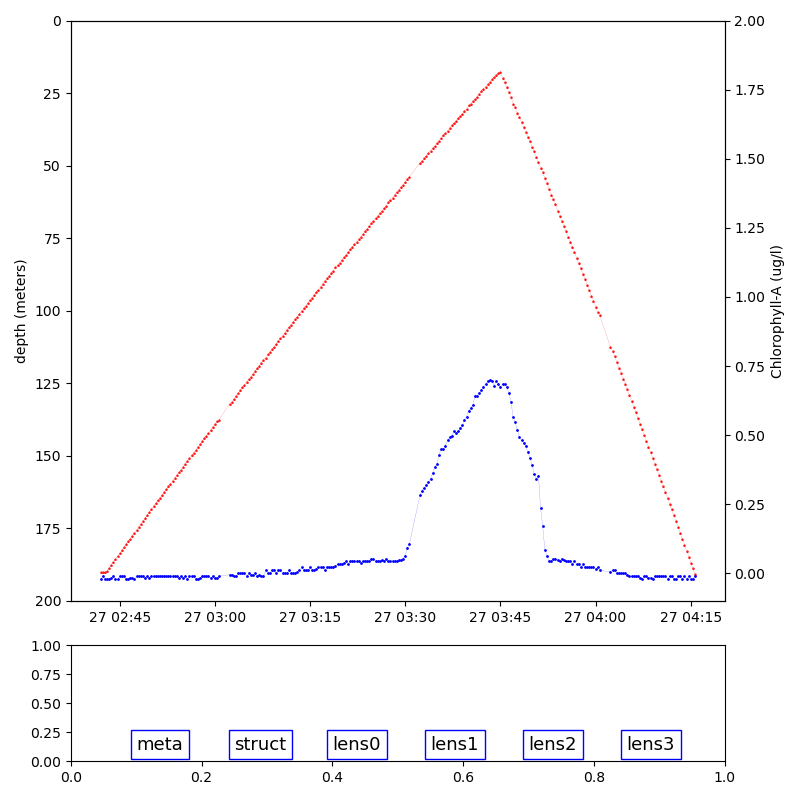

In [5]:
##############
#
# Annotation
#
##############



modes = {0:'meta', 1:'struct', 2:'lens0', 3:'lens1', 4:'lens2', 5:'lens3'}

# p_index_start is 180
p_index_progress = 212
# p_index_stop is 885

# initialize the dataframe and operating modes
columns_metadata = ['index', 'ascent start', 'depth start', 'ascent end', 'depth minimum', 'descent end', 'descent end', 'profile type', 'remark']

remark_index = len(columns_metadata) - 1

columns_structure = [                             \
        't00', 'd00', 'c00', 't01', 'd01', 'c01', \
        't02', 'd02', 'c02', 't03', 'd03', 'c03', \
        't04', 'd04', 'c04', 't05', 'd05', 'c05', \
        't06', 'd06', 'c06', 't07', 'd07', 'c07', \
        't08', 'd08', 'c08', 't09', 'd09', 'c09', \
        't10', 'd10', 'c10', 't11', 'd11', 'c11']


columns_lens0 = ['l0_t00', 'l0_d00', 'l0_c00', 'l0_t01', 'l0_d01', 'l0_c01', 'l0_t02', 'l0_d02', 'l0_c02', 'l0_t03', 'l0_d03', 'l0_c03']
columns_lens1 = ['l1_t00', 'l1_d00', 'l1_c00', 'l1_t01', 'l1_d01', 'l1_c01', 'l1_t02', 'l1_d02', 'l1_c02', 'l1_t03', 'l1_d03', 'l1_c03']
columns_lens2 = ['l2_t00', 'l2_d00', 'l2_c00', 'l2_t01', 'l2_d01', 'l2_c01', 'l2_t02', 'l2_d02', 'l2_c02', 'l2_t03', 'l2_d03', 'l2_c03']
columns_lens3 = ['l3_t00', 'l3_d00', 'l3_c00', 'l3_t01', 'l3_d01', 'l3_c01', 'l3_t02', 'l3_d02', 'l3_c02', 'l3_t03', 'l3_d03', 'l3_c03']


df = pd.DataFrame(columns = columns_metadata + columns_structure + columns_lens0 + columns_lens1 + columns_lens2 + columns_lens3)
p_metadata  = ['']*len(columns_metadata)
p_structure = ['']*len(columns_structure)
p_lens0     = ['']*len(columns_lens0)
p_lens1     = ['']*len(columns_lens1)
p_lens2     = ['']*len(columns_lens2)
p_lens3     = ['']*len(columns_lens3)

current_mode = 1

mode_meta_capacity   = len(columns_metadata)
mode_struct_capacity = len(columns_structure)//3
mode_lens0_capacity  = len(columns_lens0)//3
mode_lens1_capacity  = len(columns_lens1)//3
mode_lens2_capacity  = len(columns_lens2)//3
mode_lens3_capacity  = len(columns_lens3)//3

def ResetModeIndices():
    global mode_struct_ix, mode_lens0_ix, mode_lens1_ix, mode_lens2_ix, mode_lens3_ix
    mode_struct_ix = -1
    mode_lens0_ix  = -1
    mode_lens1_ix  = -1
    mode_lens2_ix  = -1
    mode_lens3_ix  = -1
    return

ResetModeIndices()

########################
#
# Functions
#
########################

def ClearList(l): 
    for i in range(len(l)): l[i] = ''          # operates on a mutable list

def ClearRecord(ll):
    for i in range(len(ll)): ClearList(ll[i])       # operates on a list of mutable lists

def PType(peak_time):
    midn0 = dt64(str(peak_time)[:11] + '08:00')         # UTC times corresponding to approximate local midnight, noon
    midn1 = dt64(str(peak_time)[:11] + '09:00')         # No adjustment is made to timing during daylight savings:
    noon0 = dt64(str(peak_time)[:11] + '21:10')         #   These UTC ranges are valid throughout the year.
    noon1 = dt64(str(peak_time)[:11] + '22:10')
    if  peak_time > midn0 and peak_time < midn1: return 'midn'       # midnight profile: stepped descent
    if  peak_time > noon0 and peak_time < noon1: return 'noon'       # noon profile: stepped descent
    return 'quot'                                                    # quotidian profile: continuous/smooth descent


###########
#
# Chlor A bias
# 
###########


chla_bias = -.0321

##################
##################
##
## chart and event handler
##
##################
##################


%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from time import sleep

####################
#
# mouse event (click event)
#
####################

def mouse_event(event):
    
    global D, D_this, D_this_median
    global p, p_index_this, p_index_stop
    global data, data_t0, data_tm, data_t1
    global modes, current_mode, mode_struct_capacity, mode_lens_capacity
    global mode_meta_ix, mode_struct_ix, mode_lens0_ix, mode_lens1_ix, mode_lens2_ix, mode_lens3_ix
    global mode_meta_capacity, mode_struct_capacity, mode_lens0_capacity, mode_lens1_capacity, mode_lens2_capacity, mode_lens3_capacity
    global text_axs1_1, text_axs1_2
    global t0_this, tm_this, t1_this

    
    msg1 = 'mode: ' + modes[current_mode]
    msg1 = msg1 + ';  profile type: ' + PType(tm_this)
    msg1 = msg1 + '   start: ' + str(p['ascent_start'][p_index_this])[:13] + '    '

    
    # click in main chart
    if str(event.inaxes)[23:28] == '.2486':           # axs[0]
        
        if current_mode == 0:
            p_metadata[remark_index] = input('Remark: ')
            
        elif current_mode == 1:
            struct_msg = '1' if mode_struct_ix == -1 else str((mode_struct_ix + 1) % mode_struct_capacity + 1)
            msg1 = msg1 + struct_msg + '/' + str(mode_struct_capacity) + '  '
            msg1 = msg1 + str(mode_lens0_ix + 1)  + '/' + str(mode_lens0_capacity)  + '  '
            msg1 = msg1 + str(mode_lens1_ix + 1)  + '/' + str(mode_lens1_capacity)  + '  '
            msg1 = msg1 + str(mode_lens2_ix + 1)  + '/' + str(mode_lens2_capacity)  + '  '
            msg1 = msg1 + str(mode_lens3_ix + 1)  + '/' + str(mode_lens3_capacity)

            this_date_str = str(mdates.num2date(event.xdata))
            this_date     = dt64(this_date_str[:19])
            this_y        = round(event.ydata, 3)
            data          = D_this_median.sel(time=this_date, method="nearest")
            data_dt64     = str(data.time.data)[:19]
            data_chla     = str(round(float(data.chlora) - chla_bias, 4))
            data_depth    = str(round(float(data.depth), 3))
            msg2          = data_chla + '    ' + data_depth + '    ' + data_dt64

            # Add this click to struct or lensX depending on mode
            # struct only for now
            mode_struct_ix += 1
            if mode_struct_ix == mode_struct_capacity:
                mode_struct_ix = 0
                ClearList(p_structure)
            p_structure[3*mode_struct_ix]     = data_dt64
            p_structure[3*mode_struct_ix + 1] = data_depth
            p_structure[3*mode_struct_ix + 2] = data_chla
            
        else:
            a = 0  # dummy; this is lenses
            
    # the click was in the control chart
    else:
        # lower 1/4 is mode select
        if event.ydata < 0.25:
            xloc = event.xdata
            if xloc < 0.2: p_metadata[remark_index] = 'remark placeholder'
            
        # upper 3/4 is the 'next profile' trigger
        else: 
            # finish and save the about-to-be-prior profile's information...
            data_t0 = D_this_median.sel(time=t0_this, method="nearest")
            data_tm = D_this_median.sel(time=tm_this, method="nearest")
            data_t1 = D_this_median.sel(time=t1_this, method="nearest")

            # fill in the metadata
            p_metadata[0] = str(p_index_this)
            p_metadata[1] = str(t0_this)
            p_metadata[2] = str(round(float(data_t0.depth), 2))
            p_metadata[3] = str(tm_this)
            p_metadata[4] = str(round(float(data_tm.depth), 2))
            p_metadata[5] = str(t1_this)
            p_metadata[6] = str(round(float(data_t1.depth), 2))
            p_metadata[7] = PType(tm_this)

            df.loc[len(df.index)] = p_metadata + p_structure + p_lens0 + p_lens1 + p_lens2 + p_lens3
            df.to_csv('./chla_annotate.csv')
            ClearRecord([p_metadata, p_structure, p_lens0, p_lens1, p_lens2, p_lens3])
            ResetModeIndices()

            p_index_this += 1
            mode_struct_ix = -1
            
            # either halt...
            if p_index_this > p_index_stop: 
                msg1 = 'all done with profiles'
                msg2 = '   ...ah reckon'

            # ...or load the next profile
            else:
                t0_this       = p['ascent_start'][p_index_this]
                tm_this       = p['ascent_end'][p_index_this]
                t1_this       = p['descent_end'][p_index_this]    

                D_this        = D.sel(time=slice(t0_this, t1_this))
                D_this_median = D_this.resample(time='20S').median().dropna('time')
                
                axtwinChlA.clear()
                axtwinChlA.set(ylim = (-.1, 2.0), ylabel='Chlorophyll-A (ug/l)')
                axtwinChlA.plot(D_this_median.time, D_this_median.chlora, ms = 2., marker='.', linewidth=.1, color='b')

                axs[0].clear()
                axs[0].set(ylim = (200., 0.), ylabel='depth (meters)')
                axs[0].plot(D_this_median.time, D_this_median.depth,  ms = 1., marker='^', linewidth=.1, color='r')

                fig.canvas.draw()
    
    text_axs1_1 = axs[1].text(0.05, .75, msg1, color='k', fontsize=10)
    text_axs1_1.set_bbox(bbd1)
    text_axs1_2 = axs[1].text(0.05, .50, msg2, color='r', fontsize=10)
    text_axs1_2.set_bbox(bbd2)
    
    fig.canvas.draw()
    # fig.canvas.flush_events()
    # plt.show()



###############
#
# profile indexing
#
###############

p_index_this = p_index_progress

#################
#
# chart
#
#################

plt.rcParams["figure.autolayout"] = True
fig,axs = plt.subplots(2, figsize=(8,8), gridspec_kw={'height_ratios': [5,1]})
fig.canvas.mpl_connect('button_press_event', mouse_event)
# axtwinFDOM = axs[0].twinx()
# axtwinBB7C = axs[0].twinx()
axtwinChlA = axs[0].twinx()

t0_this = p['ascent_start'][p_index_this]
tm_this = p['ascent_end'][p_index_this]
t1_this = p['descent_end'][p_index_this]  
D_this        = D.sel(time=slice(t0_this, t1_this))
D_this_median = D_this.resample(time='20S').median().dropna('time')
    
# set up the depth plot
axtwinChlA.set(ylim = (-.1, 2.0), ylabel='Chlorophyll-A (ug/l)')
axtwinChlA.plot(D_this_median.time, D_this_median.chlora, ms = 2., marker='.', linewidth=.1, color='b')

axs[0].set(ylim = (200., 0.), ylabel='depth (meters)')
axs[0].plot(D_this_median.time, D_this_median.depth,  ms = 1., marker='^', linewidth=.1, color='r')

bbd1 = dict(facecolor='white', alpha=1.0, edgecolor='b')
bbd2 = dict(facecolor='white', alpha=1.0, edgecolor='magenta')

modebox = [axs[1].text(0.1 + 0.15*i, .10, modes[i], color='k', fontsize = 13) for i in range(6)]
for i in range(6): modebox[i].set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='blue'))

plt.show()




In [6]:
D

<xarray.Dataset>
Dimensions:                          (time: 5830998)
Coordinates:
  * time                             (time) datetime64[ns] 2021-01-23T12:00:0...
Data variables:
    chlora                           (time) float64 ...
    fdom                             (time) float64 ...
    backscatter                      (time) float64 ...
    seawater_scattering_coefficient  (time) float64 ...
    practical_salinity               (time) float64 ...
    seawater_temperature             (time) float64 ...
    int_ctd_pressure                 (time) float64 ...
    depth                            (time) float64 ...

### Profiles


This section shifts from time-series view to profile view. It necessarily folds the
ascent/descent back on itself by means of 2-meter depth bins. 

In [7]:
C = xr.open_dataset('../../data/rca/fluor/osb/2021/flort_fullres.nc')
C = C.swap_dims({'obs':'time'})
C = C.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})
C = C[['chlora', 'fdom', 'backscatter', 'seawater_scattering_coefficient', \
       'practical_salinity', 'seawater_temperature', 'int_ctd_pressure'    ]]
C = C.drop(['obs', 'lat', 'lon'])
# Did not use C = C.reset_coords() to move coords to data variables
C.attrs={}                               

In [8]:
###########
#
# Chlor A bias
# 
###########


chla_bias = -.0321


KeyboardInterrupt: 

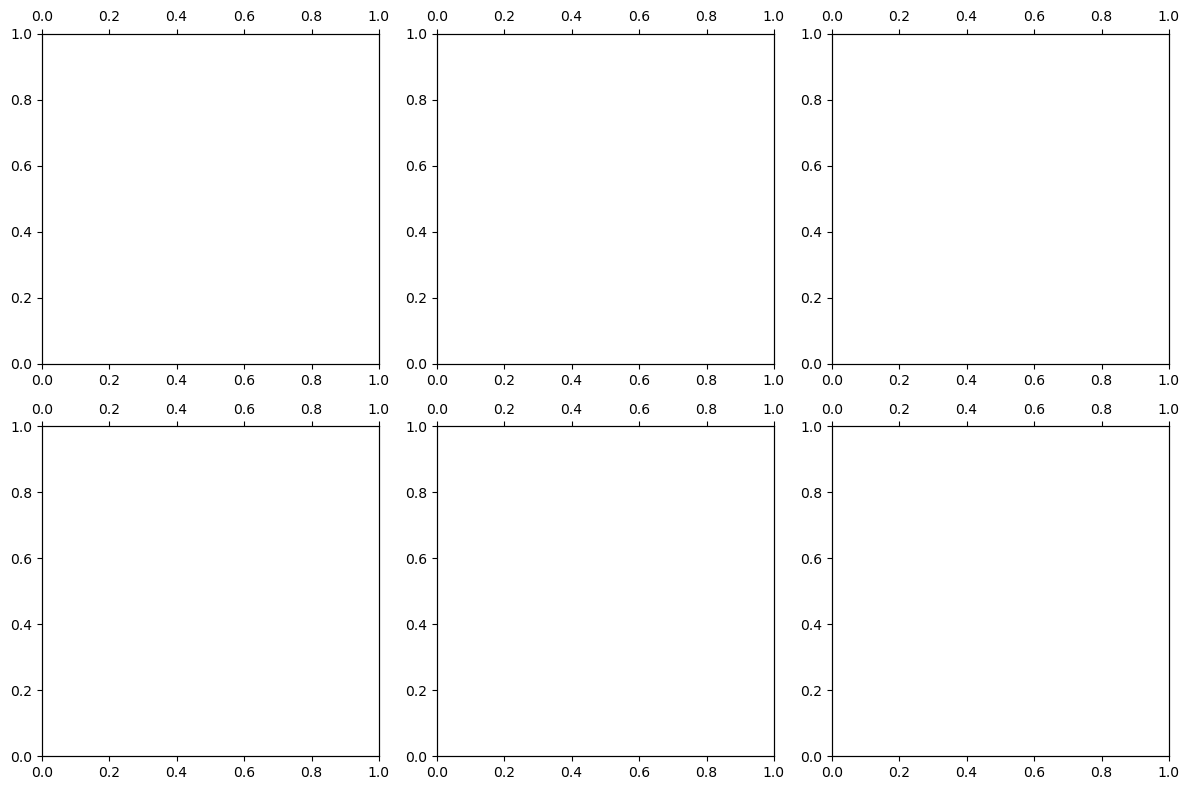

In [9]:
%matplotlib inline

zb = [i for i in range(0, 201, 2)]
zl = [i for i in range(1, 200, 2)]

# usable range of profiles is 180 through 885
np   =   2      # number of charts down, top to bottom
na   =   3      # number of charts across, left to right
poff = 500      # index of starting profile
fig,ax = plt.subplots(np, na, figsize=(4*na,4*np))
tx = [[ax[i, j].twiny() for j in range(na)] for i in range(np)]

for i in range(np):
    p_ix      = poff + i 
    t0, t1    = p['ascent_start'][p_ix], p['descent_end'][p_ix]  
    CP        = C.sel(time=slice(t0, t1)).swap_dims({"time":"depth"}).sortby('depth')
    CP_mean   = CP.groupby_bins('depth', zb, labels=zl).mean().dropna('depth_bins')
    CP_std    = CP.groupby_bins('depth', zb, labels=zl).std().dropna('depth_bins')

    ax[i][0].plot(CP_mean.chlora - chla_bias, CP_mean.depth_bins, c='xkcd:green')
    tx[i][0].plot(CP_std.chlora,              CP_std.depth_bins,  c='xkcd:mahogany', lw=.3)
    ax[i][0].set(ylim = (200., 0.), ylabel='depth (meters)', xlim=(0.0, 2.0))
    tx[i][0].set(ylim = (200., 0.),                          xlim=(0.0, 0.3))

    ax[i][1].plot(CP_mean.fdom, CP_mean.depth_bins, c='red')
    tx[i][1].plot(CP_std.fdom,  CP_std.depth_bins,  c='xkcd:mahogany', lw=.3)
    ax[i][1].set(ylim = (200., 0.), ylabel='depth (meters)', xlim=(0.0, 2.0))
    tx[i][1].set(ylim = (200., 0.),                          xlim=(0.0, 0.6))

    ax[i][2].plot(CP_mean.backscatter, CP_mean.depth_bins, c='xkcd:dark cyan')
    tx[i][2].plot(CP_std.backscatter,  CP_std.depth_bins,  c='xkcd:mahogany', lw=.3)
    ax[i][2].set(ylim = (200., 0.), ylabel='depth (meters)', xlim=(0.0006, 0.003))
    tx[i][2].set(ylim = (200., 0.),                          xlim=(0.0, 0.004))

fig.show()

In [216]:
# fig.savefig("../../biooptics_profiles_600_699_2021.png")

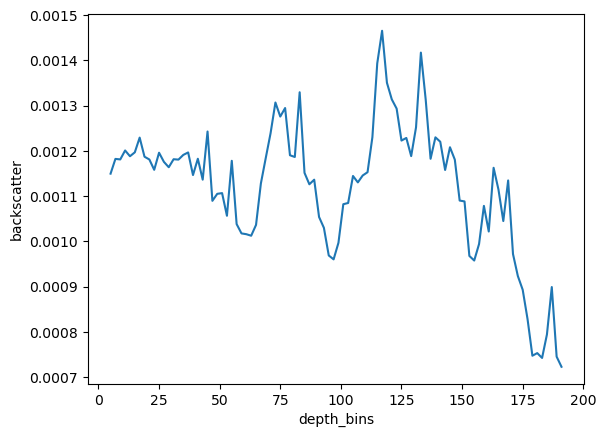

In [19]:
CP_mean.backscatter.plot()

In [20]:
def SimpleMedian(a, n):
    '''
    Returns a list by applying an n-odd element median filter to list `a`: Handle both 
    edges, deal with even filter widths. For a set with an even number of elements the
    bias is towards low. This filter does not make use of a control/noise list such as std.
    '''
    def M(q):
        '''returns a float'''
        ql = len(q)
        if ql == 0: return 0.
        if ql == 1: return q[0]
        
        # q[] has 2 or more elements: Sort and return middle or middle-low
        q.sort()
        return q[(ql-1) // 2]

    l, b = len(a), []
    if n < 3:     n  = 3
    if not n % 2: n += 1         # filter width even? increase to odd
    fhw = n // 2
    for i in range(l):
        bd_l = 0 if i - fhw     < 0 else i - fhw
        bd_r = l if i + fhw + 1 > l else i + fhw + 1
        aa = a[bd_l:bd_r]      # copy sub-range to new list
        b.append(M(aa))
    return b

In [24]:
bb700 = [float(c) for c in CP_mean.backscatter]
bb700_SM = SimpleMedian(bb700, 5)
medback = xr.DataArray(bb700_SM, dims=['depth_bins'])
CP_mean['medback'] = medback

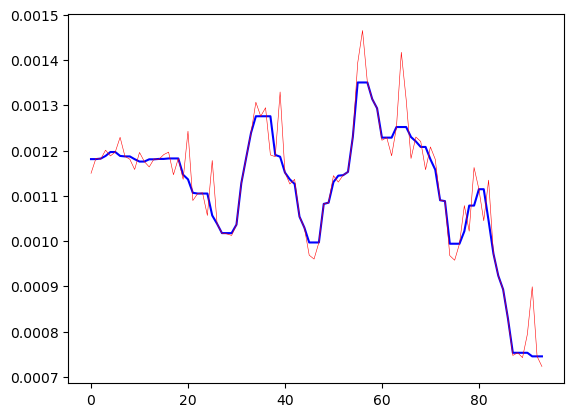

In [29]:
fig,ax=plt.subplots()
ax.plot(CP_mean.medback, color='b')
ax.plot(CP_mean.backscatter, color='r', lw=0.4)

In [224]:
s1

[0.0297741906784308,
 0.03975573881657784,
 0.07209251961308462,
 0.08019767182821871,
 0.05521956766631225,
 0.08056183850042951,
 0.05464693167344634,
 0.05695787460299006,
 0.049625263294166055,
 0.06288899088955936,
 0.04049351455304522,
 0.038127874151680535,
 0.04312690880911537,
 0.03744957539441832,
 0.041905730568409835,
 0.033154455141975195,
 0.04649324921128036,
 0.056736631587439953,
 0.034258398711698515,
 0.0677140848634085,
 0.1395616385831006,
 0.04270684134471802,
 0.02583003048778688,
 0.20481350203852272,
 0.23118221621015042,
 0.20818665747190646,
 0.10349150913348784,
 0.12399329120740782,
 0.0831034838648231,
 0.02927003639484508,
 0.02597997109549006,
 0.028413339519730796,
 0.021457860225377597,
 0.0187823817095473,
 0.01606179465804027,
 0.019543571114857064,
 0.012426590615329193,
 0.019739279634079728,
 0.01641896551724138,
 0.028704484385243964,
 0.02070156323978334,
 0.018131385874196385,
 0.016049978782456727,
 0.016678392714982233,
 0.017406347214767207,